# Import libraries and setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='3'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('waveglow/')

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import pickle as pkl
import torch
import hparams
from torch.utils.data import DataLoader
from modules.model import Model
from text import text_to_sequence, sequence_to_text
from denoiser import Denoiser
from tqdm import tqdm_notebook as tqdm
import librosa

data_type = 'phone'
checkpoint_path = f"training_log/transformer-tts-{data_type}/checkpoint_200000"
state_dict = {}
for k, v in torch.load(checkpoint_path)['state_dict'].items():
    state_dict[k[7:]]=v


model = Model(hparams).cuda()
model.load_state_dict(state_dict)
_ = model.cuda().eval()

# Data filtering

In [2]:
datasets = ['train', 'val', 'test']

for dataset in datasets:
    with open(f'filelists/ljs_audio_text_{dataset}_filelist.txt', 'r') as f:
        lines = [line.split('|') for line in f.read().splitlines()]

    for i in tqdm(range(len(lines))):
        file_name, _, text = lines[i]
        text = '^' + text + '~'
        seq = os.path.join('/media/disk1/lyh/LJSpeech-1.1/preprocessed',
                           f'{data_type}_seq')
        mel = os.path.join('/media/disk1/lyh/LJSpeech-1.1/preprocessed',
                           'melspectrogram')

        with open(f'{seq}/{file_name}_sequence.pkl', 'rb') as f:
            text_padded = pkl.load(f).unsqueeze(0)
        with open(f'{mel}/{file_name}_melspectrogram.pkl', 'rb') as f:
            mel_padded = pkl.load(f).unsqueeze(0)
            
        text_lengths=torch.LongTensor([text_padded.size(1)])
        mel_lengths=torch.LongTensor([mel_padded.size(2)])
        
        _, melspec, _, _, alignments, _ = model.outputs(text_padded.cuda(),
                                                        mel_padded.cuda(),
                                                        text_lengths.cuda(),
                                                        mel_lengths.cuda())


        melspec = melspec[0]
        alignments = alignments[0]
        
        F = torch.mean(torch.max(alignments, dim=-1)[0], dim=-1)
        r, c = torch.argmax(F).item()//4, torch.argmax(F).item()%4
        location = torch.max(alignments[r,c], dim=1)[1]
        
        diff = location[1:]-location[:-1]
        # First alignment easily failed
        init_att = torch.zeros(1, alignments.size(-1))
        init_att[0,0]=1
        diff = diff[1:]
        valid_data = torch.all(torch.abs(diff)<=3)

        if valid_data:
            with open(f'{hparams.teacher_path}/targets/{file_name}.pkl', 'wb') as f:
                pkl.dump(melspec.detach().cpu(), f)
            with open(f'{hparams.teacher_path}/alignments/{file_name}.pkl', 'wb') as f:
                align = torch.cat([init_att, alignments[r,c, 1:].detach().cpu()], dim=0)
                pkl.dump(align, f)

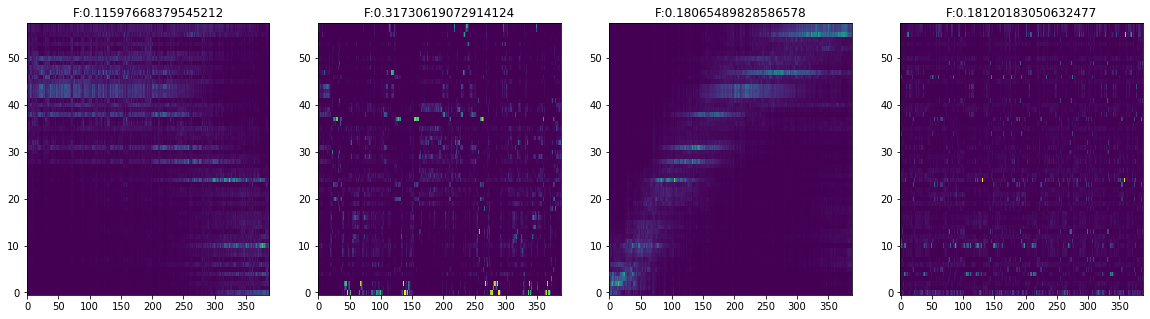

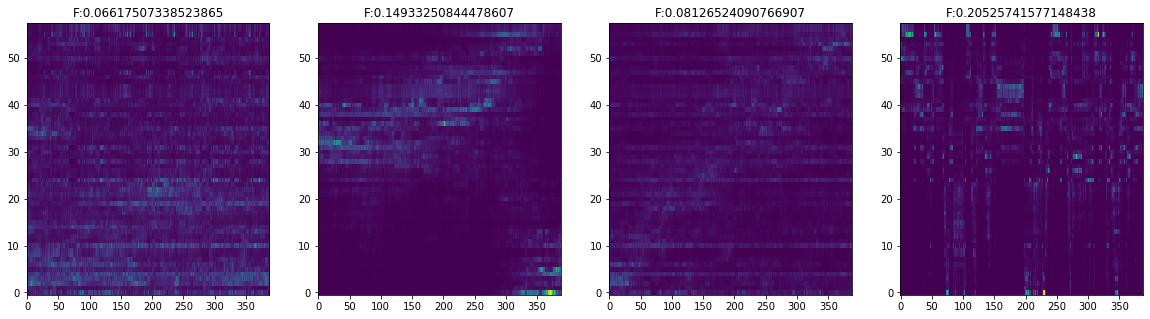

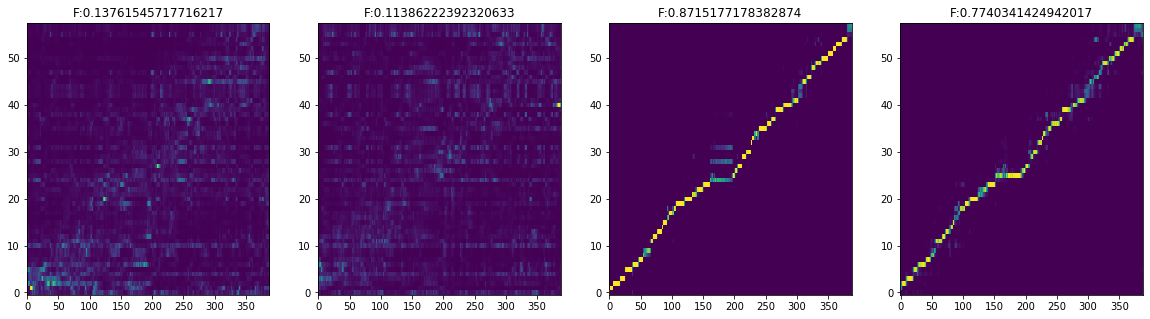

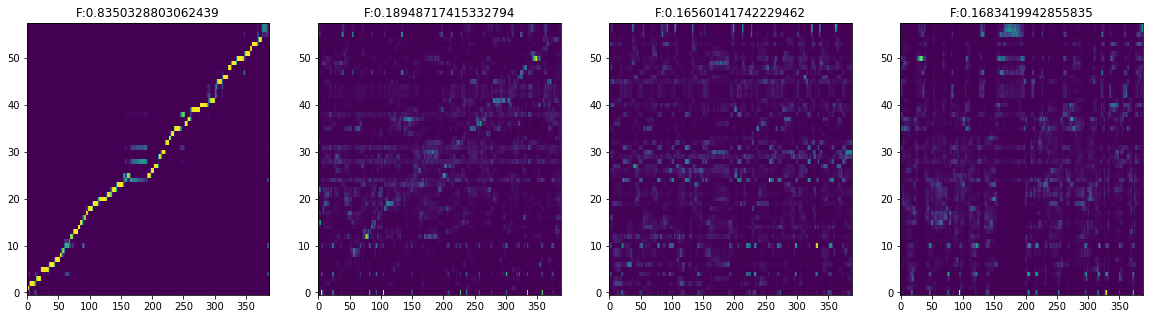

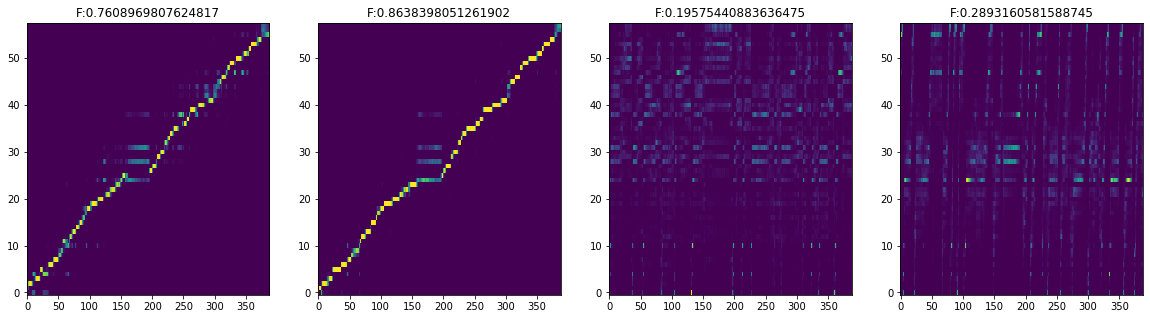

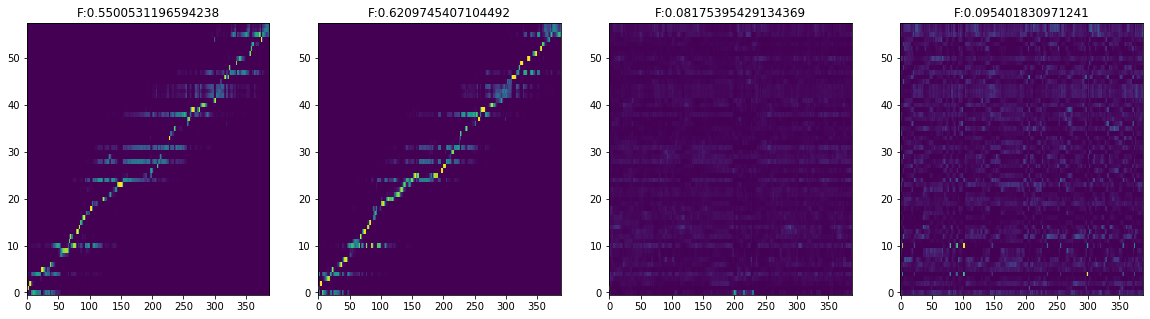

In [4]:
for i in range(hparams.n_layers):
    fig, axes=plt.subplots(1,4, figsize=(20,5))
    for j in range(hparams.n_heads):
        axes[j].imshow(alignments[i][j].detach().cpu().t(), origin='lower', aspect='auto')
        axes[j].set_title(f'F:{F[i,j]}')
    plt.show()

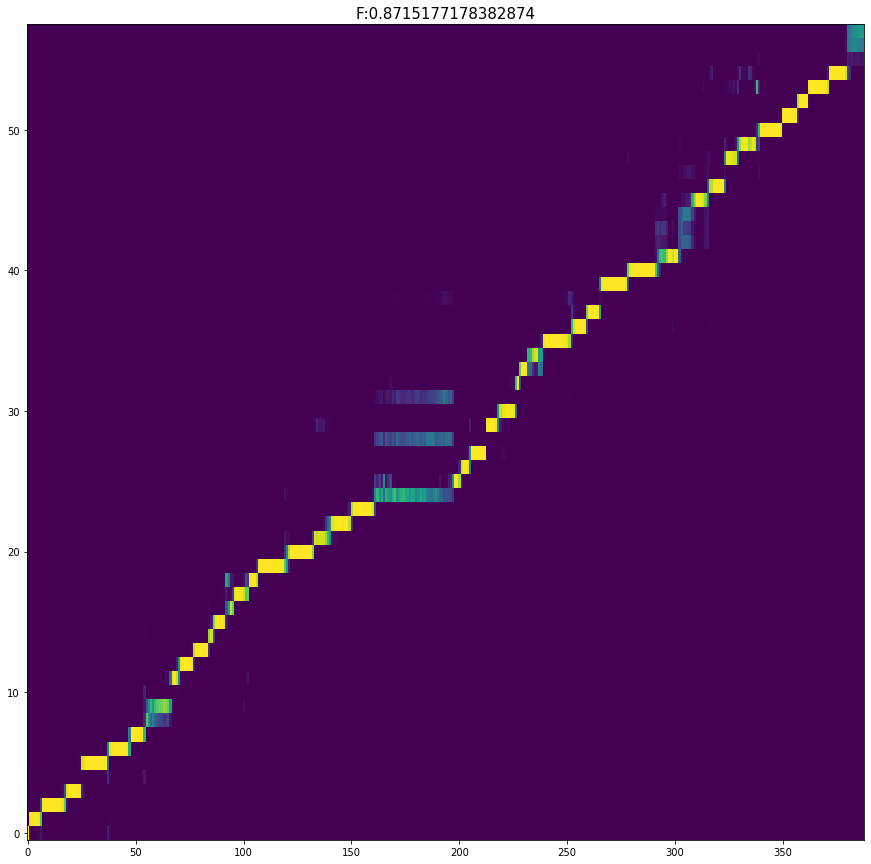

In [6]:
plt.figure(figsize=(15,15))
plt.imshow(alignments[r,c].detach().cpu().t(), origin='lower', aspect='auto')
plt.title(f'F:{F[r,c]}', fontsize=15)
plt.show()